In [116]:
print("test")

test


In [117]:
# simple social-graph based simulation
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numba.cuda
import time
import numba
import random
from numba import jit
import numpy as np
from numpy import *
from numba import njit, prange
from numba import cuda, float32
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import statistics
import seaborn
#import cupy as cp
import pandas as pd
import networkx as nx

import math
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [118]:
#subroutines for contagion, testing, contact counting and random graph generation

#test and isolate (delay or no delay)
@jit('int32[:](int8[:],int8[:],int8[:,:],float32[:],float32[:],int8[:],int8[:])', fastmath=True, nogil=True, cache=True, parallel=True)
def test_and_isolate_jit(virus_input, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay):
        
        change = np.int32([0,0])
        
        testing_strategy     = test_parameters[0]
        test_interval        = test_parameters[1]
        test_true_positive   = test_parameters[2]
        isolation_compliance = test_parameters[3]
        isolate_contacts     = test_parameters[4]
        test_time            = test_parameters[5]
        contact_bias         = test_parameters[6]
        test_delay_time      = test_parameters[7]
        trace_delay_time     = test_parameters[8]
        
        current_contact_bias = 1
        
        if (testing_strategy == 1):
            test_probability = 1 / test_interval
        else:
            test_probability = 1
        
        # random test 
        for j in prange(len(virus_input)):
            # test
            if (testing_strategy >= 1):
                if (contact_bias > 0): 
                    current_contact_bias = contact_bias * fraction_of_contacts[j]
                if ((test_time == 0 or virus_input[j] == int32(test_time)) and virus_input[j] != 0 and np.random.uniform(0, 1) < test_probability * current_contact_bias):
                    if (np.random.uniform(0, 1) < test_true_positive * isolation_compliance):
                        test_delay[j] = 1
                            
        # increments test delay vector and finds positives, sets trace delay           
        for j in prange(len(virus_input)):
            if (test_delay[j] != 0): 
                test_delay[j] += 1
            if (test_delay[j] >= 2 + test_delay_time):
                virus_input[j] = 0
                test_delay[j]  = 0
                trace_delay[j] = 1
        
        # increments trace delay vector and isolates contacts
        if (isolate_contacts > 0):
            for j in prange(len(virus_input)):
                if (trace_delay[j] != 0): 
                    trace_delay[j] += 1
                if (trace_delay[j] >= 2 + trace_delay_time):
                    for k in prange(len(social_graph)):
                        if (k != j and social_graph[k][j] > 0 and np.random.uniform(0, 1) < isolation_compliance * isolate_contacts):
                            virus_input[k] = 0
                            test_delay[k]  = 0
                            trace_delay[j] = 0

        # counts immune and infected
        for j in range(len(social_graph[0])):
            change[0] += (virus_input[j] != 0)
            change[1] += (immunity[j] == 0)
                             
        return(change)
    
    
#stepwise discrete contagion
@njit('int32[:](int8[:],int8[:],int8[:,:],int8[:],float32,int8)', fastmath=True, nogil=True, cache=True, parallel=True)
def discrete_contagion_jit(virus_input, immunity, social_graph, virus_tmp, transmission_probability, fixed_value):
        change = np.int32([0,0])
        graphsize = len(social_graph)
        for j in prange(graphsize):
            if (virus_input[j] != 0):
                
                for k in range(graphsize):
                    if (social_graph[k][j] * immunity[k] > 0):
                        if (k != j and np.random.uniform(0, 1) < transmission_probability):
                            virus_tmp[k] = fixed_value
                            immunity[k]  = 0

                virus_tmp[j] = virus_input[j] - 1
                                
        for j in range(graphsize):
            virus_input[j] = virus_tmp[j]
            change[0] += (virus_tmp[j] != 0)
            change[1] += (immunity[j] == 0)
                             
        return(change)

#counts all non-self (diagonal) contacts from graph
@njit('int32(int8[:,:])', fastmath=True, parallel=False)
def count_contacts_jit_parallel(social_graph):
    contacts = np.int32(0)
    for i in range(len(social_graph[0])):
        for j in range(len(social_graph)):
            if (i == j): continue
            contacts += social_graph[i][j]
    return (contacts) 

#count number of incoming contacts
@njit('void(int8[:,:], int32[:])', fastmath=True, parallel=True)
def count_number_of_incoming_contacts_jit_parallel(social_graph, number_of_contacts):
    for j in prange(len(social_graph[0])):
        for k in prange(len(social_graph)):
            if (social_graph[j][k] == 0): continue
            if (j == k): continue
            number_of_contacts[k] += 1         
            
#generates random graph to (matrix) with diagonal of one (directly modifies data).
#cell values will be modified to exact value at probability_of_modifying_value 
#if exact value is -1, random value between 0 and max_value is used instead
@njit('void(int8[:,:], float32, int8, int8)', parallel=False)
def random_graph_diagonal_one_jit_parallel(graph_matrix, probability_of_modifying_value, exact_value, max_value):
    for j in range(len(graph_matrix[0])):
        for k in range(len(graph_matrix)):
            # adds value to a random cell
            if (random.uniform(0, 1) < probability_of_modifying_value):
                if (exact_value == 0): 
                    graph_matrix[j][k] = random.uniform(0, max_value)
                else: 
                    graph_matrix[j][k] = exact_value
                # makes matrix symmetric
                graph_matrix[k][j] = graph_matrix[j][k]
            # makes diagonal = 1
            if (j == k):
                graph_matrix[j][k] = 1    
                

In [119]:
# SUBROUTINE TO RUN ONE SIMULATION WITH TEST
@jit(parallel = False)
def simulation_with_test(virus, immunity, social_graph, odd_vector, fraction_of_contacts, test_parameters, test_delay, trace_delay, daily_transmission_probability):
    
    for days in range (1,4096):
        
        odd_vector = np.zeros(matrix_size, dtype=np.int8)
        change     = discrete_contagion_jit(virus,immunity,social_graph,odd_vector,daily_transmission_probability,infectious_period)
        #print (daily_transmission_probability, sum(virus))
        if (test_parameters[0] == 1):
            change = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
        if (test_parameters[0] == 2 and days % test_parameters[1] == 0):
            change = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
        else:
            # inactivates test but runs the subroutine to move delays
            save_value         = test_parameters[2]
            test_parameters[2] = 0
            change     = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
            test_parameters[2] = save_value
        immune     = change[1]
        infected   = change[0]
        #print(days, infected)
        if (infected == 0): 
            break
    
    return (days,immune) 

# subroutine that initializes a model and runs a simulation
def initialize_and_run(name, test_parameters, output_data, daily_transmission_probability):
    
    test_delay                              = np.zeros(matrix_size, dtype=np.int8)
    trace_delay                             = np.zeros(matrix_size, dtype=np.int8)
    virus                                   = np.zeros(matrix_size, dtype=np.int8)
    immunity                                = np.ones (matrix_size, dtype=np.int8)
    odd_vector                              = np.zeros(matrix_size, dtype=np.int8)
    
    virus[simulations*start_from_fraction]    = infectious_period
    immunity[simulations*start_from_fraction] = 0
    
    result = simulation_with_test(virus, immunity, social_graph, odd_vector, fraction_of_contacts, test_parameters, test_delay, trace_delay, daily_transmission_probability)
    
    if (simulations % 200 == 0): print(R0, name, simulations, time.time()-start, result)
    output_data.at[total_simulations+simulations, (name+'_days')] = result[0]
    output_data.at[total_simulations+simulations, name] = result[1]

In [120]:
# sets up social graph
infectious_period          = 42
matrix_size                = 4000
average_number_of_contacts = 20
contacts                   = np.int32(0)

# fully connected
graph_type          = "Fully connected"
social_graph        = np.ones(shape=(matrix_size,matrix_size), dtype=np.int8)

# sets up social graph (Random)
graph_type        = "Random graph"
social_graph      = np.zeros(shape=(matrix_size,matrix_size), dtype=np.int8)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 2), 1, 0)

# Barabasi_Albert
# graph_type        = "Barabasi Albert"
# social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//2)
# social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int8)
# for x in range(matrix_size):
#     social_graph[x][x] = 1

# determines contacts per individual for current graph
contacts                = count_contacts_jit_parallel(social_graph)
contacts_per_individual = contacts / matrix_size


start_from_fraction    = 1
number_of_simulations  = matrix_size // start_from_fraction

start        = time.time()
output_data  = pd.DataFrame()

test_parameters      = np.zeros(10, dtype=np.float32)

test_parameters[0] = 1                         #testing_strategy (1 = random, 2 = all at the same time)
test_parameters[1] = float32(infectious_period)        #test_interval
test_parameters[2] = 0.70                      #test_true_positive 
test_parameters[3] = 0.75                      #isolation_compliance
test_parameters[4] = 0                         #isolate_contacts (tracing efficiency)
test_parameters[5] = 0                          #test time relative to infectious period (0 is all the time)
#test_parameters[5] = infectious_period//2      #test_time
test_parameters[6] = 0                         #fractional_bias_based_on_contact_freq
test_parameters[7] = 0                         #test delay time
test_parameters[8] = 0                         #trace delay time
parameter_memory = np.copy(test_parameters)

# counts number of contacts for each individual, and determines fraction of contacts
number_of_contacts              = np.zeros(matrix_size, dtype=np.int32)
count_number_of_incoming_contacts_jit_parallel(social_graph, number_of_contacts)
fraction_of_contacts = np.array(np.divide(number_of_contacts, statistics.mean(number_of_contacts)), dtype=np.float32)


In [ ]:
# Simulation across a parameter range (test interval using a random test)

# sets up R0
#R0           = 2.8569
#R0           = 2.35
start               = time.time()
#R0range             = np.linspace(1.2,3.5,num=10)
#R0range             = [1.2100,1.4899,1.7616,2.0255,2.2818,2.5310,2.7732,3.0088,3.2380,3.4612]
#R0range             = [1.6850,2.0628,2.4253,2.7735,3.1081,3.4300,3.7398,4.0383,4.3260,4.6035]
#R0range             = [1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]
R0range             = [1.2100,1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]

#test_interval_range = list([1000000,496])+ list(range(496,248,-24)) + list(range(248,124,-12)) + list(range(168,84,-6)) + list(range(84,42,-3)) + list(range(42,5,-1))
test_interval_range   = list([1000000,1000])+ list(range(496,248,-96)) + list(range(248,124,-48)) + list(range(168,84,-24)) + list(range(84,51,-6))  + list(range(51,42,-3)) + list(range(42,5,-1))


simulations         = 0
total_simulations   = 0

for R0 in R0range:  
    for test_parameters[1] in test_interval_range:
    # sets daily transmission probability based on contacts per individual and R0
        daily_transmission_probability = R0 / (contacts_per_individual * infectious_period)
        print(contacts, contacts_per_individual, daily_transmission_probability, daily_transmission_probability * contacts_per_individual * infectious_period)
        for simulations in range (number_of_simulations):
            if (test_parameters[1] == 42):
                output_data.at[simulations+total_simulations, "R0"] = R0
            initialize_and_run("interval_"+str(test_parameters[1]), test_parameters, output_data, daily_transmission_probability)
            #print(simulations, time.time()-start, flush=True)
    total_simulations += simulations        

print(time.time()-start, flush=True)

78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_1000000.0 0 0.5645303726196289 (84, 2)
1.21 interval_1000000.0 200 29.95564079284668 (1534, 1094)
1.21 interval_1000000.0 400 59.49659252166748 (42, 1)
1.21 interval_1000000.0 600 89.76152348518372 (231, 14)
1.21 interval_1000000.0 800 116.94495439529419 (42, 1)
1.21 interval_1000000.0 1000 151.92130398750305 (1066, 972)
1.21 interval_1000000.0 1200 183.62078022956848 (1044, 1325)
1.21 interval_1000000.0 1400 216.17835521697998 (173, 14)
1.21 interval_1000000.0 1600 253.23562908172607 (81, 3)
1.21 interval_1000000.0 1800 285.24889874458313 (57, 2)
1.21 interval_1000000.0 2000 320.0281937122345 (1271, 1096)
1.21 interval_1000000.0 2200 353.8776044845581 (42, 1)
1.21 interval_1000000.0 2400 387.133517742157 (42, 1)
1.21 interval_1000000.0 2600 425.89790177345276 (1022, 1365)
1.21 interval_1000000.0 2800 464.2012493610382 (42, 1)
1.21 interval_1000000.0 3000 498.52819991111755 (1310, 935)
1.21 interval_1000000.0 3200 527.

In [ ]:
#newsim = output_data.iloc[:, 112:]
newsim = output_data
print(len(newsim), len(newsim))
newsim

### len(test_interval_range)

In [ ]:
# saves data
compression_opts = dict(method='zip',
                        archive_name='all_4k_random_sim_intervals_R0_up_to_'+str(R0)+'.csv')  
output_data.to_csv('all_4k_random_sim_intervals_R0_up_to_'+str(R0)+'.zip', index=False,
          compression=compression_opts)

1.21
1.4901
1.7618
2.0257
2.2821
2.5312
2.7735
3.0091
3.2384
3.4615


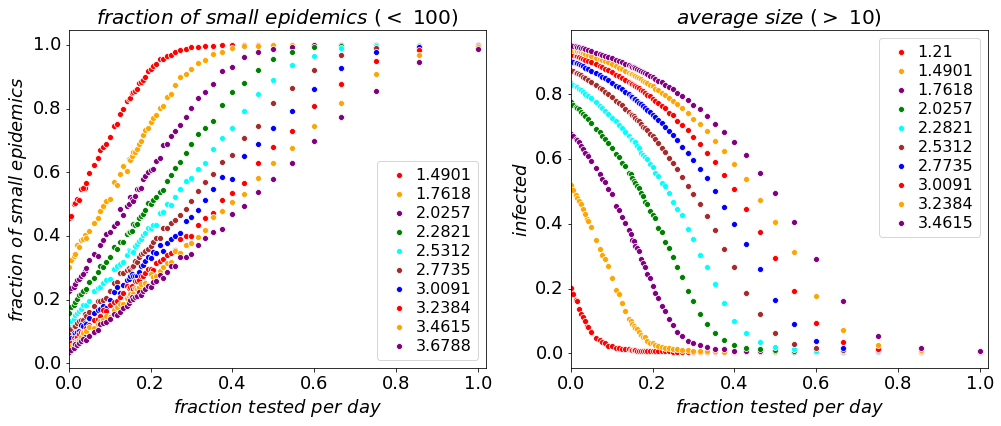

In [133]:
import seaborn
from itertools import compress

newsim    = output_data
colorlist = ['red','orange','purple','green','cyan','brown','blue','red','orange','purple']
R0range   = [1.2100,1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]

Fig5 = plt.figure(figsize=(14,6))

daily_fraction       = []
max_size             = []
average_size         = []
average_large_size   = []
less_than_100        = []
R0s                  = []
max_size_over_fraction_of_large = []

#test_interval_range = range (42,0,-1)
for R0 in R0range:
    c = newsim['R0'] == R0
    for i in test_interval_range:
        current_column = "interval_"+str(i)+".0"
        #ax = seaborn.scatterplot(newsim[current_column + "_days"], newsim[current_column], alpha = 0.3, label = str(math.trunc(100/i)/100))
        current_sizes       = newsim[current_column][c]
        current_large_sizes = current_sizes[current_sizes > 10]
        average_size.append(statistics.mean(current_sizes)/matrix_size)
        if (len(current_large_sizes) == 0): 
            average_large_size.append(0)
        else:
            average_large_size.append(statistics.mean(current_large_sizes)/matrix_size)
        max_fraction_infected       = max(current_sizes)/matrix_size
        fraction_of_small_epidemics = sum(current_sizes < 100) / number_of_simulations

        max_size.append(max_fraction_infected)
        less_than_100.append(fraction_of_small_epidemics)
        #if (fraction_of_large_epidemics > 0):
        #    max_size_over_fraction_of_large.append(max_fraction_infected / fraction_of_large_epidemics)
        #else:
        #    max_size_over_fraction_of_large.append(0)

        daily_fraction.append(6/i)
        R0s.append(R0)

plt.xlabel("$\itdays$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)
#ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 4, loc = 4)

plt.subplot(122)
plt.xticks(horizontalalignment='center', fontsize = 18)
plt.yticks(verticalalignment='center', fontsize = 18)
i = 0
for R0 in R0range[:-1]:
    print(R0)
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(average_large_size,c)), label = str(R0), color = colorlist[i])
    i += 1
    #ax = seaborn.scatterplot(daily_fraction, average_size, label = "average size")
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 18)
plt.ylabel("$\itinfected$", fontsize = 18)
ax.set_xlim(0,1.02)
ax.set_title("$\itaverage\ size\ (>\ 10)$", fontsize = 20)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 16, loc = 1)


plt.subplot(121)
plt.xticks(horizontalalignment='center', fontsize = 18)
plt.yticks(verticalalignment='center', fontsize = 18)
i = 0
for R0 in R0range[1:]:
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(less_than_100,c)), label = str(R0), color = colorlist[i])
    i += 1
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 18)
plt.ylabel("$\itfraction\ of\ small\ epidemics$", fontsize = 18)
ax.set_xlim(0,1.02)
ax.set_title("$\itfraction\ of\ small\ epidemics\ (<\ 100)$", fontsize = 20)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 16, loc = 4)

plt.tight_layout(pad=1, h_pad=1, w_pad=2, rect=None)
Fig5.savefig("Fig5CD.pdf")
Fig5.savefig("Fig5CD.png", dpi=600)

In [ ]:
# code for other types of social graph (using NetworkX to generate, reformat as numpy matrix)

# sets up social graph (Random)
graph_type        = "Random graph"
social_graph      = np.zeros(shape=(matrix_size,matrix_size), dtype=np.int32)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 2), 1, 0)

# 50-50 Mix of Barabasi_Albert and Random
graph_type        = "Barabasi Albert : Random 50:50"
social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//4)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int32)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 4), 1, 0)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)
    
# Small world
graph_type        = "Watts Strogatz small world"
social_network    = nx.watts_strogatz_graph(n=matrix_size, k=average_number_of_contacts, p=0.2, seed=None)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int32)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)
    
# Barabasi_Albert
graph_type        = "Barabasi Albert"
social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//2)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int32)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)
